Initializing System

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [0]:
!tar xf "/content/drive/My Drive/BigDataAssignment3Files/spark-2.4.5-bin-hadoop2.7.tgz"
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
spark = SparkSession.builder.master("local[*]").getOrCreate()

Reading Preprocessed Dataset

In [0]:
preprocessed_data = spark.read.json("hdfs://udit_gupta_1/processed_data")

Extract Data for EDA

In [0]:
#Get top 30 crime types in complaints
top30_crime_type = preprocessed_data.rdd \
.filter(lambda row : row['RECORD_TYPE'] == 'C') \
.map(lambda row : (row['OFNS_DESC'],1)) \
.reduceByKey(lambda key1, key2 : key1 + key2) \
.takeOrdered(30,lambda atuple: -atuple[1])

In [0]:
complaints_crime_list = [ele[0] for ele in top30_crime_type if ele[0] is not None]

In [0]:
#Get top 30 arrests crime types
top30_arrests_crime_type = preprocessed_data.rdd \
.filter(lambda row : row['RECORD_TYPE'] == 'A') \
.map(lambda row : (row['OFNS_DESC'],1)) \
.reduceByKey(lambda key1, key2 : key1 + key2) \
.takeOrdered(30,lambda atuple: -atuple[1])

In [0]:
arrests_crime_list = [ele[0] for ele in top30_arrests_crime_type if ele[0] is not None]

In [0]:
#Get top 30 location types for crime complaints
top30_crime_locations = preprocessed_data.rdd \
.filter(lambda row : row['RECORD_TYPE'] == 'C') \
.map(lambda row : (row['PREM_TYP_DESC'],1)) \
.reduceByKey(lambda key1, key2 : key1 + key2) \
.takeOrdered(30,lambda atuple: -atuple[1])

In [0]:
complaints_location_list = [ele[0] for ele in top30_crime_locations if ele[0] is not None]

Generate Pivot Tables for Different Attributes

In [0]:
#Pivot Table based on Location
location_groupby = preprocessed_data \
.filter(preprocessed_data['RECORD_TYPE'] == 'C') \
.filter(preprocessed_data.PREM_TYP_DESC.isin(complaints_location_list)) \
.groupby('PREM_TYP_DESC')
location_crime_pivot = location_groupby.pivot("OFNS_DESC", complaints_crime_list).agg({"*": "count"}).fillna(0).toPandas()
location_crime_pivot = location_crime_pivot.set_index('PREM_TYP_DESC')

In [0]:
#Pivot Table based on ethinicity
ethinicity_crime_pivot =  preprocessed_data \
.filter(preprocessed_data['RECORD_TYPE'] == 'C') \
.groupby('SUSP_RACE').pivot("OFNS_DESC", complaints_crime_list).agg({"*": "count"}).fillna(0).toPandas()

ethinicity_crime_pivot = ethinicity_crime_pivot.set_index('SUSP_RACE')

In [0]:
#Pivot Table for age-group
age_crime_pivot =  preprocessed_data \
.filter(preprocessed_data['RECORD_TYPE'] == 'C') \
.groupby('SUSP_AGE_GROUP').pivot("OFNS_DESC", complaints_crime_list).agg({"*": "count"}).fillna(0).toPandas()

age_crime_pivot = age_crime_pivot.set_index('SUSP_AGE_GROUP')

In [0]:
#Pivot Table for gender
gender_crime_pivot = preprocessed_data \
.filter(preprocessed_data['RECORD_TYPE'] == 'C') \
.groupby('SUSP_SEX').pivot("OFNS_DESC", complaints_crime_list).agg({"*": "count"}).fillna(0).toPandas()

gender_crime_pivot = gender_crime_pivot.set_index('SUSP_SEX')

In [0]:
#Pivot Table for precicnt codes
borough_crime_pivot =  preprocessed_data \
.filter(preprocessed_data['RECORD_TYPE'] == 'C') \
.groupby('BORO_NM').pivot("OFNS_DESC", complaints_crime_list).agg({"*": "count"}).fillna(0).toPandas()

borough_crime_pivot = borough_crime_pivot.set_index('BORO_NM')

Corrospondence Analysis

In [0]:
from numpy.linalg import svd
import numpy as np
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class CA(object):
    """Simple corresondence analysis.
    
    Inputs
    ------
    ct : array_like
      Two-way contingency table. If `ct` is a pandas DataFrame object,
      the index and column values are used for plotting.
    Notes
    -----
    The implementation follows that presented in 'Correspondence
    Analysis in R, with Two- and Three-dimensional Graphics: The ca
    Package,' Journal of Statistical Software, May 2007, Volume 20,
    Issue 3.
    """

    def __init__(self, ct):
        self.rows = ct.index.values if hasattr(ct, 'index') else None
        self.cols = ct.columns.values if hasattr(ct, 'columns') else None
        
        # contingency table
        N = np.matrix(ct, dtype=float)

        # correspondence matrix from contingency table
        P = N / N.sum()

        # row and column marginal totals of P as vectors
        r = P.sum(axis=1)
        c = P.sum(axis=0).T

        # diagonal matrices of row/column sums
        D_r_rsq = np.diag(1. / np.sqrt(r.A1))
        D_c_rsq = np.diag(1. / np.sqrt(c.A1))

        # the matrix of standarized residuals
        S = D_r_rsq * (P - r * c.T) * D_c_rsq

        # compute the SVD
        U, D_a, V = svd(S, full_matrices=False)
        D_a = np.asmatrix(np.diag(D_a))
        V = V.T

        # principal coordinates of rows
        F = D_r_rsq * U * D_a

        # principal coordinates of columns
        G = D_c_rsq * V * D_a

        # standard coordinates of rows
        X = D_r_rsq * U

        # standard coordinates of columns
        Y = D_c_rsq * V

        # the total variance of the data matrix
        inertia = sum([(P[i,j] - r[i,0] * c[j,0])**2 / (r[i,0] * c[j,0])
                       for i in range(N.shape[0])
                       for j in range(N.shape[1])])

        self.F = F.A
        self.G = G.A
        self.X = X.A
        self.Y = Y.A
        self.inertia = inertia
        self.eigenvals = np.diag(D_a)**2

    def plot(self):
        """Plot the first and second dimensions."""
        xmin, xmax = None, None
        ymin, ymax = None, None
        if self.rows is not None:
            for i, t in enumerate(self.rows):
                x, y = self.F[i,0], self.F[i,1]
                plt.text(x, y, t, va='center', ha='center', color='green')
                xmin = min(x, xmin if xmin else x)
                xmax = max(x, xmax if xmax else x)
                ymin = min(y, ymin if ymin else y)
                ymax = max(y, ymax if ymax else y)
        else:
            plt.plot(self.F[:, 0], self.F[:, 1], 'ro')

        if self.cols is not None:
            for i, t in enumerate(self.cols):
                x, y = self.G[i,0], self.G[i,1]
                plt.text(x, y, t, va='center', ha='center', color='r')
                xmin = min(x, xmin if xmin else x)
                xmax = max(x, xmax if xmax else x)
                ymin = min(y, ymin if ymin else y)
                ymax = max(y, ymax if ymax else y)
        else:
            plt.plot(self.G[:, 0], self.G[:, 1], 'bs')

        if xmin and xmax:
            pad = (xmax - xmin) * 0.1
            plt.xlim(xmin - pad, xmax + pad)
        if ymin and ymax:
            pad = (ymax - ymin) * 0.1
            plt.ylim(ymin - pad, ymax + pad)

        plt.grid()
        plt.xlabel('Dim 1')
        plt.ylabel('Dim 2')

    def scree_diagram(self, perc=True, *args, **kwargs):
        """Plot the scree diagram."""
        eigenvals = self.eigenvals
        xs = np.arange(1, eigenvals.size + 1, 1)
        ys = 100. * eigenvals / eigenvals.sum() if perc else eigenvals
        plt.plot(xs, ys, *args, **kwargs)
        plt.xlabel('Dimension')
        plt.ylabel('Eigenvalue' + (' [%]' if perc else ''))

Generating Plots

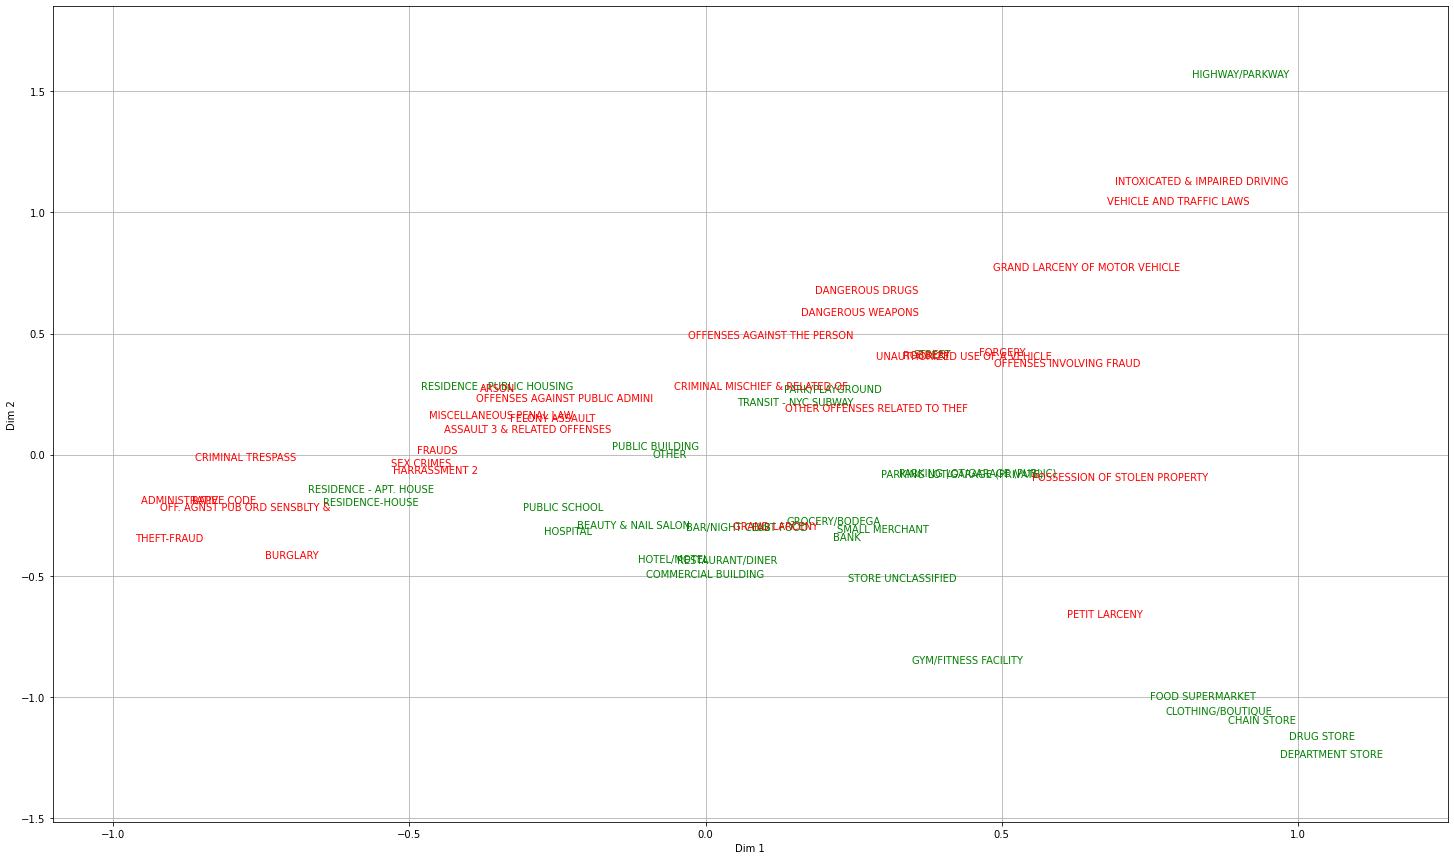

In [31]:
ca = CA(location_crime_pivot)
plt.figure(figsize=(25,15))
ca.plot()

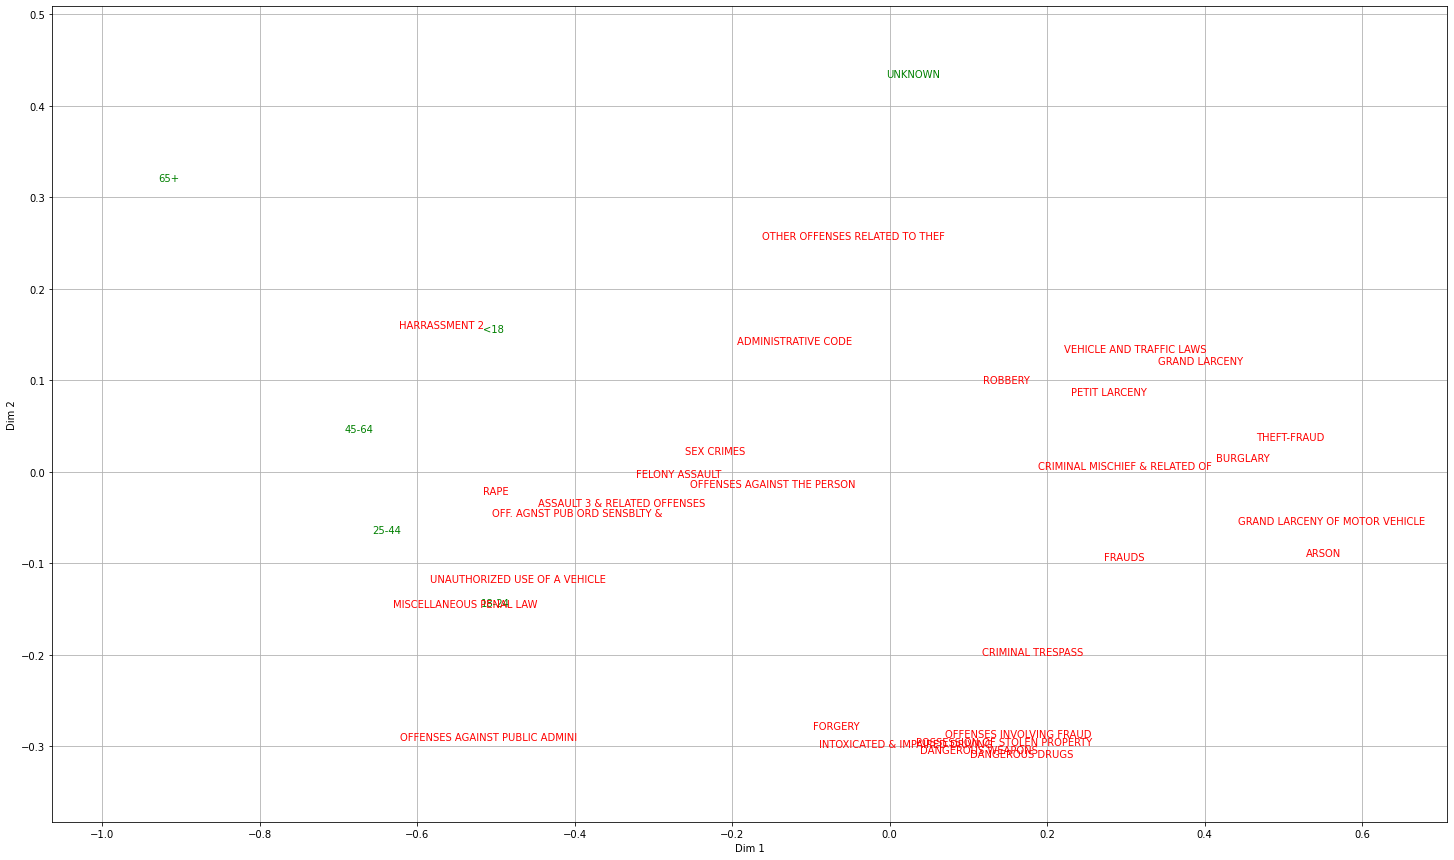

In [32]:
ca = CA(age_crime_pivot)
plt.figure(figsize=(25,15))
ca.plot()

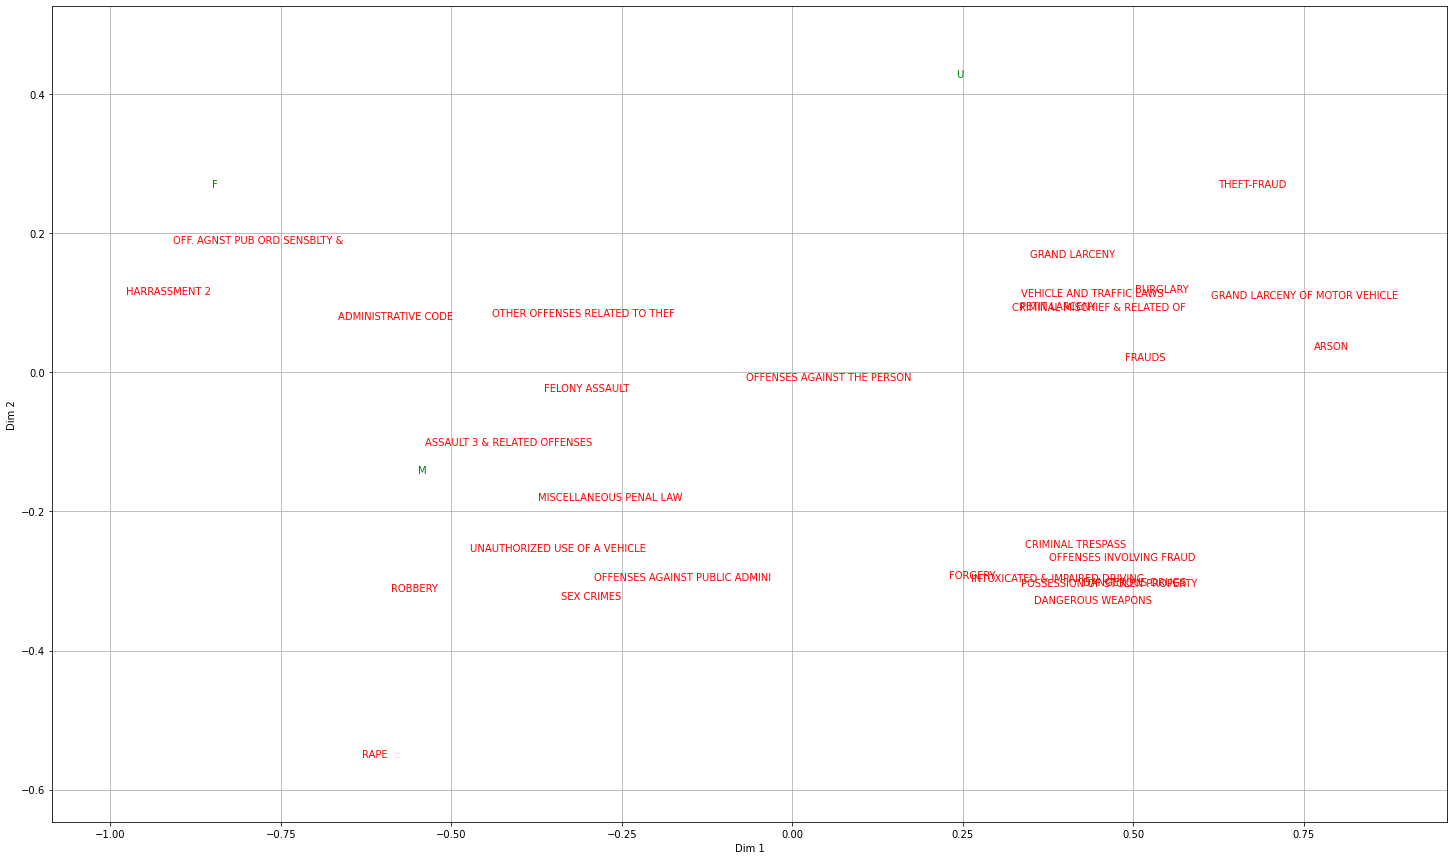

In [33]:
ca = CA(gender_crime_pivot)
plt.figure(figsize=(25,15))
ca.plot()

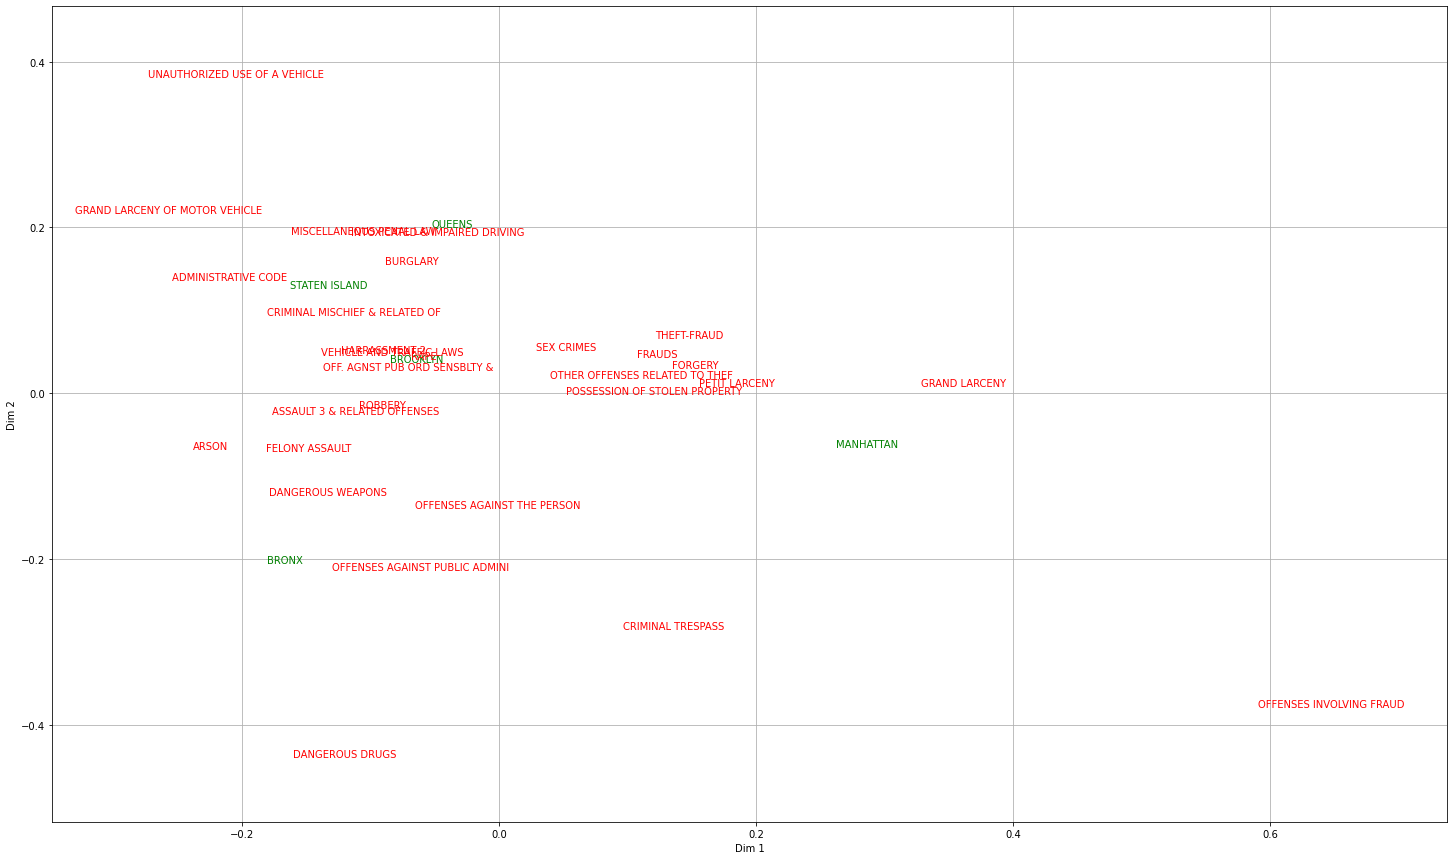

In [34]:
ca = CA(borough_crime_pivot)
plt.figure(figsize=(25,15))
ca.plot()

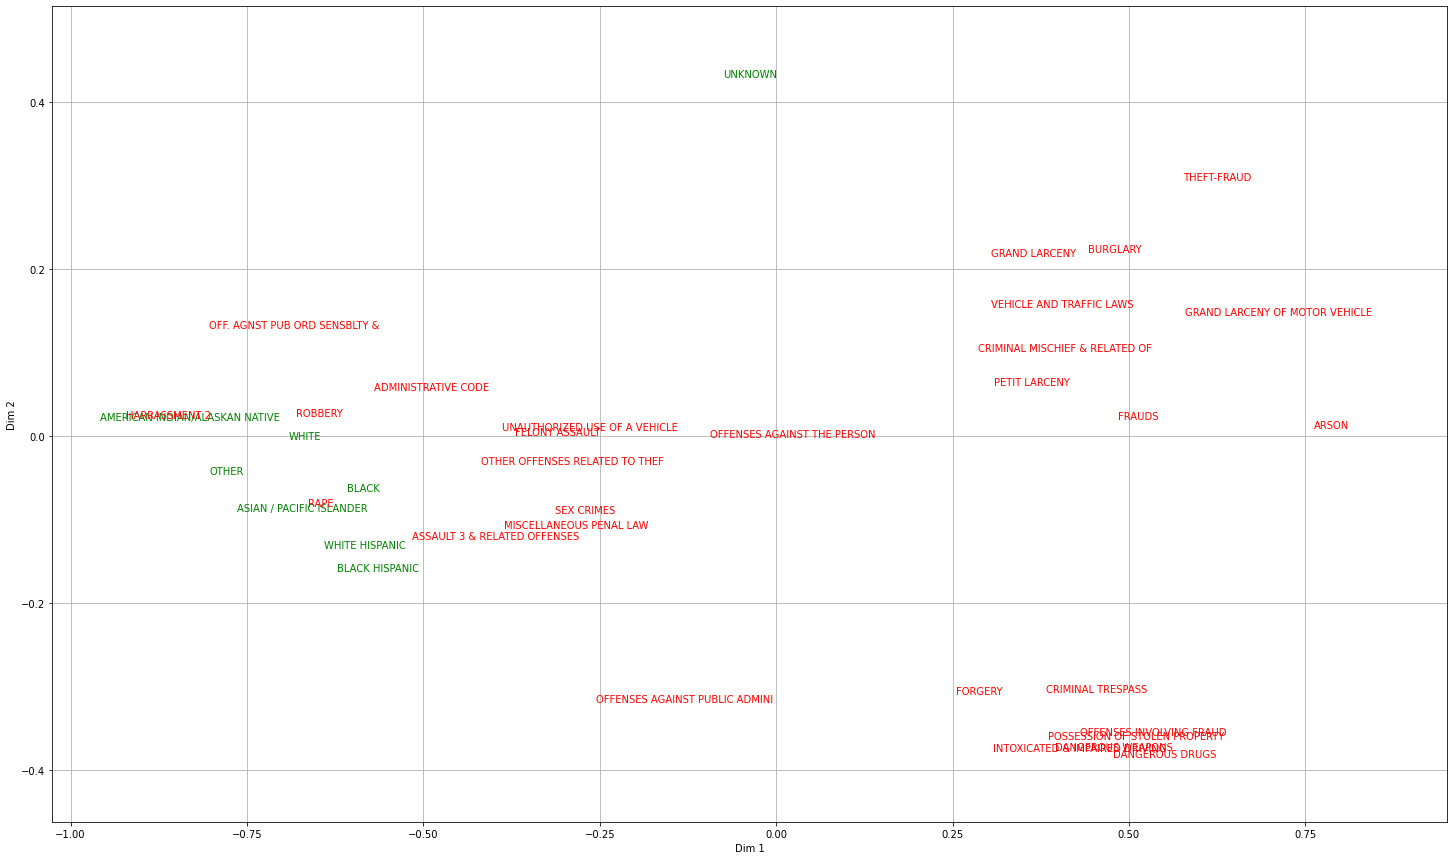

In [35]:
ca = CA(ethinicity_crime_pivot)
plt.figure(figsize=(25,15))
ca.plot()